In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [18]:
data = pd.read_csv('Data/data 258.csv')
data.head()

,Unnamed: 0,UNITID,EFFYLEV,LSTUDY,XEYTOTLT,EFYTOTLT,XEYTOTLM,EFYTOTLM,XEYTOTLW,EFYTOTLW,...,diverse_ind_std,annual_cost_std,avg_award_sqrt_std,pct_awarded_sqrt_std,GRNRALT_rate_std,logit_intl_pct,TUITION2_std,avg_award_std,pct_awarded_std,logit
0,0,107044,2,1,R,4789,R,2101,R,2688,...,-1.726940,-2.352586,0.010589,1.210253,-0.093704,-2.646689,-1.623191,-0.317656,1.965755,-2.646689
1,1,109785,2,1,R,6263,R,2141,R,4122,...,1.549113,-0.051556,-0.735559,-1.160270,-0.735287,-3.654268,-0.167906,-0.870936,-0.899768,-3.654268
2,2,110413,2,1,R,3207,R,1392,R,1815,...,1.108905,-0.150939,0.292282,0.313240,0.722638,-3.264918,0.147635,-0.021935,0.207421,-3.264918
3,3,110510,2,1,R,19244,R,7694,R,11550,...,0.076189,-2.319545,-0.648466,-1.160270,0.196608,-2.549053,-2.656479,-0.823571,-0.899768,-2.549053
4,4,111081,2,1,R,991,R,421,R,570,...,1.274542,0.564100,-1.598646,-1.160270,0.446135,-1.662439,0.622462,-1.094357,-0.899768,-1.662439


In [116]:
features = ['GRNRALT_rate','TUITION2','diverse_ind','avg_award','pct_awarded']
features_std = []
for i in range(len(features)):
    features_std.append(features[i]+'_std')

In [118]:
#.to_csv('Data/data 258.csv')


In [54]:
# current final model
# standardize
scaler = StandardScaler()
scaler.fit(data[features])
print(scaler.mean_)
print(scaler.var_)
transformed_linear = LinearRegression()
result = transformed_linear.fit(X = scaler.transform(data[features]), y = data.logit)
y_pred = result.predict(X = scaler.transform(data[features]))
#result.score(X = scaler.transform(data[features]), y = data.logit) #0.267
result.coef_

[7.11656745e-01 3.90300039e+04 4.73340628e-01 1.22454496e+04
 2.41863135e-01]
[5.10928644e-02 1.57022837e+08 2.04325156e-02 1.25207820e+08
 7.22567601e-02]


C:\Users\Ning\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([0.27159511, 0.23671089, 0.23144125, 0.08441141, 0.02364637])

In [90]:
# how do I suggest actionable insight?
# exclude tuition
# strategy: suggest the one with the biggest return on investment, if move up in the distribution by 10th percentile
# exception: graduation rate above median
# take one school
value = 109785
inst_value = data[data.UNITID==value][features]
feature = features[1]
#print(inst_value[feature].values[0])
percent = np.mean(data[feature]<=inst_value[feature].values[0])
print(feature, percent)
new_percent = np.min([percent + 0.1, 1])
print(new_percent)
new_inst_value = np.percentile(data[feature], new_percent)
print(new_inst_value)


TUITION2 0.3372093023255814
0.4372093023255814
4432.700093023256


In [135]:
def get_percentile(feature, inst_value):
    feature_value = inst_value[feature].values[0]
    percent = np.mean(data[feature]< feature_value)
    new_percent = np.min([percent + 0.1, 1])
    new_feature_value = np.percentile(data[feature], new_percent*100)
    return {'feature_value':feature_value, 
            'percent':percent, 
            'new_feature_value':new_feature_value, 
            'new_percent':new_percent}
    
update = get_percentile(features[1], inst_value)
print(update)
string = "your current {} is {}, better than {}% of the institutions. If you increase your {} to {} (better than {}% of the institutions)"
print(string.format(feature, 
                    str(update['feature_value']), 
                    str(round(update['percent']*100,1)),
                    feature, 
                    str(update['new_feature_value']),
                    str(round(update['new_percent']*100,1))
                   )
     )


{'feature_value': 36926, 'percent': 0.3333333333333333, 'new_feature_value': 39625.0, 'new_percent': 0.43333333333333335}
your current TUITION2 is 36926, better than 33.3% of the institutions. If you increase your TUITION2 to 39625.0 (better than 43.3% of the institutions)


In [108]:
# updated prediction
def reverse_logit(logit):
    return np.exp(logit)/(1 + np.exp(logit))
def get_improvement(feature, inst_value):
    input_update = get_percentile(feature, inst_value)
    old_prediction = result.predict(X = scaler.transform(inst_value))
    old_intl_pct = reverse_logit(old_prediction[0])
    new_inst_value = inst_value.copy()
    new_inst_value[feature] = input_update['new_feature_value']
    new_prediction = result.predict(X = scaler.transform(new_inst_value))
    new_intl_pct = reverse_logit(new_prediction[0])
    increase = (new_intl_pct - old_intl_pct)*100
    return round(np.min([increase, 100]),2)
get_improvement(features[1], inst_value)


C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


0.29

In [121]:
# identify the best feature to improve
def select_best_feature(value, features):
    improvements = {}
    for feature in features:
        improvements[feature] = get_improvement(feature, inst_value)
    best_feature = max(improvements, key = improvements.get)
    return([best_feature, improvements])
select_best_feature(value, features)


C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C

['diverse_ind',
 {'GRNRALT_rate': 0.65,
  'TUITION2': 0.29,
  'diverse_ind': 0.69,
  'avg_award': 0.14,
  'pct_awarded': 0.03}]

In [134]:
best_feature = ['pct_awarded',
 {'GRNRALT_rate': 0.25,
  'TUITION2': 0.29,
  'diverse_ind': 0.69,
  'avg_award': 0.74,
  'pct_awarded': 0.03}]
def generate_recommendations(best_feature):
    if best_feature[0] == 'GRNRALT_rate':
        update = get_percentile('GRNRALT_rate', inst_value)
        string = "Currently, your international student graduation rate is {}%, better than {}% of the institutions. As a reference, your domestic student graduation rate is X%. If you boost your international graduation rate to {} (better than {}% of the institutions), you should attract an additional {}% of international students."
        output = string.format( 
            str(round(update['feature_value']*100,1)), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value']*100,1)),
            str(round(update['new_percent']*100,1)),
            str(best_feature[1]['GRNRALT_rate'])
                   )
        return output
    if best_feature[0] == 'diverse_ind':
        update = get_percentile(best_feature[0], inst_value)
        string = "Currently, your racial diversity index is {}%, better than {}% of the institutions. (*Also show a distribution of races.) If you recruit more domestic students of racial minorities, and boost your diversity index to {} (better than {}% of the institutions), you should attract an additional {}% of international students."
        output = string.format( 
            str(round(update['feature_value']*100,1)), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value']*100,1)),
            str(round(update['new_percent']*100,1)),
            str(best_feature[1][best_feature[0]])
                   )
        return output
    if best_feature[0] == 'avg_award': # still has problems!
        update = get_percentile(best_feature[0], inst_value)
        string = "Currently, your average international student receives ${} in financial aid, better than {}% of the institutions. If you increase your average financial aid to ${} (better than {}% of the institutions), you should attract an additional {}% of international students."
        output = string.format( 
            str(round(update['feature_value'])), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value'])),
            str(round(update['new_percent']*100,1)),
            str(best_feature[1][best_feature[0]])
                   )
        return output
    if best_feature[0] == 'pct_awarded': # still has problems!
        update = get_percentile(best_feature[0], inst_value)
        string = "Currently, {}% of your international students receive financial aid, better than {}% of the institutions. If you award financial aid to {}% of the international students (better than {}% of the institutions), you should attract an additional {}% of international students."
        output = string.format( 
            str(round(update['feature_value']*100,1)), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value']*100,1)),
            str(round(update['new_percent']*100,1)),
            str(best_feature[1][best_feature[0]])
                   )
        return output
generate_recommendations(best_feature)

'Currently, 0.0% of your international students receive financial aid, better than 29.8% of the institutions. If you award financial aid to 6.9% of the international students (better than 39.8% of the institutions), you should attract an additional 0.03% of international students.'

0.5038759689922481

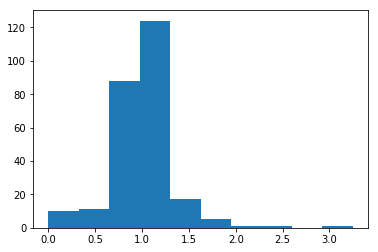

In [16]:
# look at international vs overall graduation rate
plt.hist(data.GRNRALT_rate/data.GRTOTLT_rate)
sum(data.GRNRALT_rate/data.GRTOTLT_rate<1)/258 # half schools have international graduation rate below 